# Bahceci

In [ ]:
# Importing the necessary packages
#!pip install demoji
#!pip install transformers

import ast
import re
import demoji
import matplotlib.pyplot as plt
import nltk
import pandas as pd
import spacy
import textblob
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from transformers import pipeline

nltk.download('vader_lexicon')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 1. Text Preprocessing

In [ ]:
"""
Code for data cleaning.
"""

nlp = spacy.load("en_core_web_sm")
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
nltk.download('punkt')

PATH = 'twitter_training.csv'

twitter_df = pd.read_csv(PATH)

# Run summary/descriptive statistics tests on the data
# Rename the dataframe to pre_df
pre_df = twitter_df.copy()
print("Head of the dataframe:")
print(pre_df.head())
print("\nDescriptive statistics of the dataframe:")
print(pre_df.describe())

pre_df.columns = ["ID", "Game", "Sentiment", "Text"]

# Determine if there are missing values
missing_values = pre_df.isnull().sum()
print("\nMissing values in the dataframe:")
print(missing_values)

# Drop rows with missing 'Text' values
pre_df.fillna("", inplace=True)

pre_df["ID"] = pd.to_numeric(pre_df["ID"], errors="coerce")
pre_df["ID"] = pre_df["ID"].fillna(0).astype(int)

print("Dropped na rows.")

# Lowercase the entire text
pre_df['Text'] = pre_df['Text'].str.lower()

# Remove /n from the text
pre_df['Text'] = pre_df['Text'].str.replace(r'\n.*', '', regex=True)

def remove_emojis(text):
    """
    Remove emojis, of course the emojis may effect the analysis
    as there are positive and negative emojis.
    """
    return demoji.replace(text, '')

pre_df['Text'] = pre_df['Text'].apply(remove_emojis)

print("Removed emojis")


#Correcting the spelling errors can help us as we will
#have more data that can be processed and
#it can give us more meaningful results.


# Remove all non-ASCII characters and fill with whitespace
def remove_non_ascii(text):
    """
    Function to remove non-ascii characters
    """
    cleaned_text = ""
    for char in text:
        if ord(char) < 128:
            cleaned_text += char
        else:
            cleaned_text += " "
    return cleaned_text

pre_df["Text"] = pre_df["Text"].apply(remove_non_ascii)

pre_df["Text"] = pre_df["Text"].str.strip()

print(pre_df)

# Tokenize the text and add it as a new column

pre_df['tokenized_text'] = pre_df['Text'].apply(nltk.word_tokenize)

print(pre_df)

print("tokenization done")

# Remove stopwords in the tokenized column

def remove_stopwords_nltk(tokens):
    """
    Remove stopwords nltk.
    """
    filtered = [word for word in tokens if word.lower() not in stop_words]
    return filtered

def remove_stopwords_spacy(tokens):
    """
    Remove stopwords spacy.
    """
    stopwords_set = set(nlp.Defaults.stop_words)
    filtered = [word for word in tokens if word.lower() not in stopwords_set]
    return filtered


pre_df['tokenized_text_nltk'] = pre_df['tokenized_text'].apply(
    remove_stopwords_nltk)
pre_df['tokenized_text_spacy'] = pre_df['tokenized_text'].apply(
    remove_stopwords_spacy)

print(pre_df)
print("Removed stopwords.")

# Adding 4 columns for stem and lemmas. 2 for nltk stopword
# removed column and 2 for plain tokenized column.

lemmatizer = WordNetLemmatizer()
porter = PorterStemmer()

def lemmatize(tokens):
    """Lemmatizer"""
    return [lemmatizer.lemmatize(token) for token in tokens]

def stem(tokens):
    """Stemmer"""
    return [porter.stem(token) for token in tokens]

pre_df['lemmatized_text'] = pre_df['tokenized_text'].apply(lemmatize)
pre_df['stemmed_text'] = pre_df['tokenized_text'].apply(stem)
pre_df['lemmatized_text_nltk'] = pre_df['tokenized_text_nltk'].apply(lemmatize)
pre_df['stemmed_text_nltk'] = pre_df['tokenized_text_nltk'].apply(stem)

print(pre_df)
print("Lemma and Stem columns added.")

def remove_numbers(tokens):
    """
    Removing numbers.
    """

    return [re.sub(r'\d+', '', word) for word in tokens]

pre_df['lemmatized_text_nltk'] = pre_df['lemmatized_text_nltk'].apply(
    remove_numbers)
print(pre_df)
print("removed numbers")

#Find the non-alphabetic words.

pattern = re.compile(r'[^a-zA-Z]+')

def find_non_alphabetic_words(lst):
    """Function to find non alphabetic words."""
    non_alphabetic_words = []
    for word in lst:
        if pattern.match(word):
            non_alphabetic_words.append(word)
    return non_alphabetic_words

pre_df['non_alphabetic_words'] = pre_df['lemmatized_text_nltk'].apply(
    find_non_alphabetic_words)

pre_df['lemmatized_text_nltk'] = pre_df['lemmatized_text_nltk'].apply(" ".join)

print(pre_df)
print("Found the non-alphabetic words.")


#We see that we only have punctuation at the end.
#After removing them we can only have meaningful part of the text.


#pre_df.to_csv("twitter_output.csv", index=False)

print("the end")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Head of the dataframe:
   2401  Borderlands  Positive  \
0  2401  Borderlands  Positive   
1  2401  Borderlands  Positive   
2  2401  Borderlands  Positive   
3  2401  Borderlands  Positive   
4  2401  Borderlands  Positive   

  im getting on borderlands and i will murder you all ,  
0  I am coming to the borders and I will kill you...     
1  im getting on borderlands and i will kill you ...     
2  im coming on borderlands and i will murder you...     
3  im getting on borderlands 2 and i will murder ...     
4  im getting into borderlands and i can murder y...     

Descriptive statistics of the dataframe:
               2401
count  74681.000000
mean    6432.640149
std     3740.423819
min        1.000000
25%     3195.000000
50%     6422.000000
75%     9601.000000
max    13200.000000

Missing values in the dataframe:
ID             0
Game           0
Sentiment      0
Text         686
dtype: int64
Dropped na rows.
Removed emojis
         ID         Game Sentiment  \
0      2401  Bord

In [ ]:
class DataCleaner:
    def __init__(self, file_path):
        if isinstance(file_path, str):
            self.file_path = file_path
        else:
            raise ValueError("Input needs to be a string.")

    def read_data(self):
        self.data = pd.read_csv(self.file_path)

        return self.data

    def remove_non_ascii(self, text):
        """Removing non-ascii chars."""
        cleaned_text = ""
        for char in text:
            if ord(char) < 128:
                cleaned_text += char
            else:
                cleaned_text += " "
        return cleaned_text

    def clean_data(self):
        """Cleaning the data"""

        # Rename the dataframe to pre_df
        pre_df = self.data.copy()

        pre_df.columns = ["ID", "Game", "Sentiment", "Text"]

        # Determine if there are missing values
        missing_values = pre_df.isnull().sum()

        # Drop rows with missing 'Text' values
        pre_df.fillna("", inplace=True)
        pre_df["ID"] = pd.to_numeric(pre_df["ID"], errors="coerce")
        pre_df["ID"] = pre_df["ID"].fillna(0).astype(int)

        # Lowercase the entire text
        pre_df["Text"] = pre_df["Text"].str.lower()

        pre_df["Text"] = pre_df["Text"].str.strip()
        pre_df["Words"] = pre_df["Text"].apply(lambda x: word_tokenize(x))

        pre_df["Text"] = pre_df["Text"].apply(self.remove_non_ascii)
        pre_df["Text"] = pre_df["Text"].str.strip()

        self.data = pre_df

        return self.data


    def features(self):
        """Getting the features"""
        vectorizer = CountVectorizer()
        X = vectorizer.fit_transform(self.data['Text'])

        self.data['Text_length'] = self.data['Text'].apply(len)
        print(self.data)

    def plot_text_length(self):
        """Plotting text length."""
        plt.hist(self.data['Text_length'], bins=20)
        plt.xlabel('Text Length')
        plt.ylabel('Frequency')
        plt.title('Distribution of Text Lengths')
        plt.show()

    def tokenizer(self):
        """Tokenization"""
        self.data['tokenized_text'] = self.data['Text'].apply(
            nltk.word_tokenize)
        self.data['tokenized_text'] = self.data['tokenized_text'].apply(
            ' '.join)
        print(self.data)

    def lemmatize(self):
        """Lemmatizer"""
        self.data['lemmatized_text'] = self.data['tokenized_text'].apply(
            lemmatizer.lemmatize)
        self.data['lemmatized_text'] = self.data['lemmatized_text'].apply(
            ' '.join)

    def stem(self):
        """Stemmer"""
        self.data['stemmed_text'] = self.data['lemmatized_text'].apply(
            porter.stem)
        self.data['stemmed_text'] = self.data['stemmed_text'].apply(' '.join)

## 2. Use NLTK/VADER,Textblob and Huggingface for Sentiment Analysis

In [ ]:
def score_to_sentiment(score):
    """
    Convert scores to sentiments.
    """
    if score < -0.05:
        return "Negative"
    elif score > 0.05:
        return "Positive"
    else:
        return "Neutral"

In [ ]:
sia = SentimentIntensityAnalyzer()


def sentiment_nltk(text):
    """
    Apply sentiment analysis using nltk.
    """
    sentiment = sia.polarity_scores(text)
    return sentiment["compound"]

pre_df["sentiment_nltk"] = pre_df["lemmatized_text_nltk"].apply(sentiment_nltk)
pre_df["sentiment_nltk_word"] = pre_df["sentiment_nltk"].apply(
    score_to_sentiment)

In [ ]:
def sentiment_textblob(text):
    """
    Apply sentiment analysis using TextBlob.
    """
    blob = textblob.TextBlob(text)  # Create a TextBlob object
    sentiment_score = blob.sentiment.polarity  # Get the polarity score
    return sentiment_score

pre_df["sentiment_textblob"] = pre_df["lemmatized_text_nltk"].apply(
    sentiment_textblob)
pre_df["sentiment_textblob_word"] = pre_df["sentiment_textblob"].apply(
    score_to_sentiment)

In [ ]:
# This takes more than 30 min to run, I ran it on my laptop.
huggingface_analyzer = pipeline("sentiment-analysis")
def sentiment_huggingface(text):
    """
    Apply sentiment analysis using Huggingface.
    """
    sentiment_score = huggingface_analyzer(text)  # Get the polarity score
    return sentiment_score[0]["label"]

pre_df["sentiment_huggingf"] = pre_df["lemmatized_text_nltk"].swifter.apply(
    sentiment_huggingface)
pre_df["sentiment_huggingf_word"] = pre_df["sentiment_huggingf"].str.title()

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [ ]:
print(pre_df)

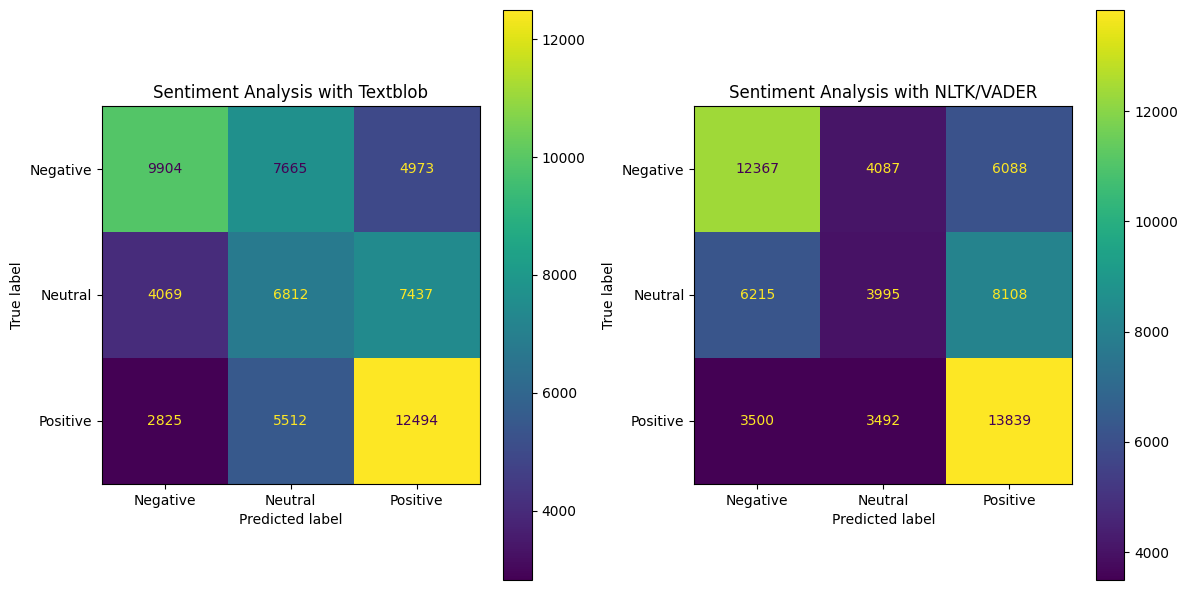

In [ ]:
#pre_df.to_csv((PATH / "combined_version.csv"), index=False)

# Drop "Irrelevant" labels for comparison
new_df = pre_df[pre_df["Sentiment"] != "Irrelevant"]

# Visualize the two prediction models with a confusion matrix
confusion_matrix1 = metrics.confusion_matrix(new_df["Sentiment"],
                                             new_df["sentiment_textblob_word"])
confusion_matrix2 = metrics.confusion_matrix(new_df["Sentiment"],
                                             new_df["sentiment_nltk_word"])

labels = ["Negative", "Neutral", "Positive"]

cm_display1 = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix1,
                                             display_labels=labels)
cm_display2 = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix2,
                                             display_labels=labels)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

cm_display1.plot(ax=axes[0])
axes[0].set_title("Sentiment Analysis with Textblob")

cm_display2.plot(ax=axes[1])
axes[1].set_title("Sentiment Analysis with NLTK/VADER")

plt.tight_layout()
plt.show()


In [ ]:
# Confusion Matrix with Huggingface

confusion_matrix3 = metrics.confusion_matrix(new_df["Sentiment"],
                                             new_df["sentiment_huggingf_word"])

cm_display3 = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix3,
                                             display_labels=labels)

cm_display3.plot(cmap=plt.cm.Blues, values_format='')

plt.title('Sentiment Analysis with Huggingface')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.show()

In [ ]:
# Running Pylint on this file.
#!pylint application_final_rbb.py


************* Module application_final_rbb
application_final_rbb.py:403:0: C0304: Final newline missing (missing-final-newline)
application_final_rbb.py:41:0: W0105: String statement has no effect (pointless-string-statement)
application_final_rbb.py:216:0: C0115: Missing class docstring (missing-class-docstring)
application_final_rbb.py:223:4: C0116: Missing function or method docstring (missing-function-docstring)
application_final_rbb.py:242:8: W0621: Redefining name 'pre_df' from outer scope (line 56) (redefined-outer-name)
application_final_rbb.py:247:8: W0621: Redefining name 'missing_values' from outer scope (line 65) (redefined-outer-name)
application_final_rbb.py:258:47: W0108: Lambda may not be necessary (unnecessary-lambda)
application_final_rbb.py:247:8: W0612: Unused variable 'missing_values' (unused-variable)
application_final_rbb.py:271:8: C0103: Variable name "X" doesn't conform to snake_case naming style (invalid-name)
application_final_rbb.py:271:8: W0612: Unused vari

#Chen

In [ ]:
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
import spacy
import seaborn as sns
import numpy as np
from nltk.corpus import stopwords
from spacy.lang.en import STOP_WORDS as stopwords_spacy
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as stopwords_sklearn
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
from sklearn.metrics import confusion_matrix
from transformers import pipeline
from textblob import TextBlob

# 1. Preprocess Twitter Dataset

* Preliminary Data Cleaning
* Advanced Data Cleaning

### Read in the twitter_training.csv

In [ ]:
# Read in the twitter_training.csv
TWITTER_FILE_PATH = "twitter_training.csv"
twitter_data = pd.read_csv(TWITTER_FILE_PATH)

### Run summary/descriptive statistics tests on the data (e.g. head, describe, etc)

In [ ]:
twitter_data_length = len(twitter_data)

print(f"Twitter Data Length: {twitter_data_length}\n")
print(twitter_data.head())
print("")
print(twitter_data.describe())

Twitter Data Length: 74681

   2401  Borderlands  Positive  \
0  2401  Borderlands  Positive   
1  2401  Borderlands  Positive   
2  2401  Borderlands  Positive   
3  2401  Borderlands  Positive   
4  2401  Borderlands  Positive   

  im getting on borderlands and i will murder you all ,  
0  I am coming to the borders and I will kill you...     
1  im getting on borderlands and i will kill you ...     
2  im coming on borderlands and i will murder you...     
3  im getting on borderlands 2 and i will murder ...     
4  im getting into borderlands and i can murder y...     

               2401
count  74681.000000
mean    6432.640149
std     3740.423819
min        1.000000
25%     3195.000000
50%     6422.000000
75%     9601.000000
max    13200.000000


### Rename this dataframe to pre_df

In [ ]:
pre_df = twitter_data.copy()

In [ ]:
# Add a row on the top of the dataframe to represent column names of each column
column_names = ["ID", "Game", "Label", "Text"]
pre_df.columns = column_names

In [ ]:
pre_df["Label"].unique()

array(['Positive', 'Neutral', 'Negative', 'Irrelevant'], dtype=object)

## Data Visualization

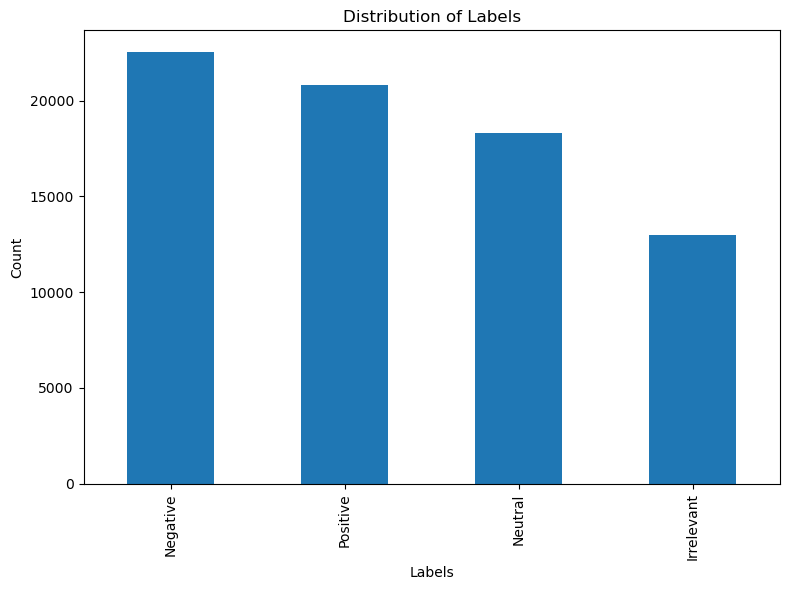

In [ ]:
label_counts = pre_df["Label"].value_counts()

plt.figure(figsize=(8, 6))
label_counts.plot(kind="bar")
plt.title("Distribution of Labels")
plt.xlabel("Labels")
plt.ylabel("Count")
# plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

## 1.1 Preliminary Data Cleaning

### Complete several text transoformations:

* Determine if there are missing values
* Determine what to fill these missing values with

In [ ]:
# Check for missing values in the "Text" column
missing_text_rows = pre_df[pre_df["Text"] == " "]

print(f"Missing Text Rows:\n {missing_text_rows}")

# Check for NaN in the "Text" column
nan_rows = pre_df[pre_df["Text"].isna()]

print(f"NaN Rows:\n {nan_rows}")

Missing Text Rows:
          ID                       Game       Label Text
2291   1602  CallOfDutyBlackopsColdWar  Irrelevant     
2993   1719  CallOfDutyBlackopsColdWar    Positive     
3239   1763  CallOfDutyBlackopsColdWar     Neutral     
3935   1880  CallOfDutyBlackopsColdWar    Negative     
4229   1929  CallOfDutyBlackopsColdWar    Negative     
...     ...                        ...         ...  ...
73229  8945                     Nvidia    Positive     
73517  8993                     Nvidia     Neutral     
73757  9036                     Nvidia    Negative     
73967  9073                     Nvidia    Positive     
74417  9154                     Nvidia    Positive     

[172 rows x 4 columns]
NaN Rows:
          ID         Game     Label Text
60     2411  Borderlands   Neutral  NaN
552    2496  Borderlands   Neutral  NaN
588    2503  Borderlands   Neutral  NaN
744    2532  Borderlands  Positive  NaN
1104   2595  Borderlands  Positive  NaN
...     ...          ...       ..

In [ ]:
# Fill missing values with "Unknown" in the "Text" column
pre_df.loc[missing_text_rows.index, "Text"] = "Unknown"
pre_df.loc[nan_rows.index, "Text"] = "Unknown"

### Change/verify relevant column data types

In [ ]:
# Check the data types of the columns
column_datatypes = pre_df.dtypes

print(column_datatypes)

ID        int64
Game     object
Label    object
Text     object
dtype: object


### Lowercase

In [ ]:
# Lower case
pre_df["Lower_Text"] = pre_df["Text"].str.lower()

### Remove non-ASCII characters and fill with whitespace

In [ ]:
# Remove all non-ASCII characters and fill with whitespace
pre_df["Remove_non_Ascii"] = pre_df["Lower_Text"].apply(lambda x: re.sub(r'[^\x00-\x7F]+', " ", x))

### Remove additional whitespace (stripping)

In [ ]:
# Remove additional whitespace (stripping)
pre_df["Remove_Whitespace"] = pre_df["Remove_non_Ascii"].str.strip()

### Split the string info into a list of strings that are each one word (tokenization)

In [ ]:
pre_df["Tokenized_Text"] = pre_df["Remove_Whitespace"].apply(word_tokenize)

## 1.2 Advanced Data Cleaning

### Remove "\n" and other symbols followed by letters

In [ ]:
# Remove "\n" and other symbols followed by letters
pre_df["Remove_n"] = pre_df["Remove_Whitespace"].apply(lambda x: re.sub(r"\n\w*", " ", x))

### Remove emojis and emoticons

Handling emojis and emoticons:

During sentiment analysis, the model only considers textual content. Elements like emojis and emoticons aren't important for the task, thus can be omitted.

However, if we aim to retain the impact of emojis and emoticons, there's a possibility to convert them into numerical values.

In [ ]:
pre_df["Remove_Emoji"] = pre_df["Remove_n"].apply(lambda x: x.encode("ascii", "ignore").decode("ascii"))

### Fix Spelling Error

Handling spelling errors:

Spelling mistakes can introduce noise in sentiment analysis tasks. One approach is to simply ignore the errors. Alternatively, we can employ libraries such as PySpellChecker or TextBlob to solve spelling issues.

In [ ]:
def correct_spelling(text):
    """Correct the spelling of the given text using TextBlob."""
    blob = TextBlob(text)
    return str(blob.correct())

pre_df["Fixed_Spelling"] = pre_df["Remove_Emoji"].apply(correct_spelling)

pre_df

### ***The execution took too long***

### Remove stopwords

In [ ]:
nltk.download("stopwords")

def remove_stopwords_nltk(text):
    """Remove stopwords from the given text using NLTK."""
    stopwords_nltk = set(stopwords.words("english"))
    tokens = word_tokenize(text)
    return " ".join([token for token in tokens if token not in stopwords_nltk])

def remove_stopwords_spacy(text):
    """Remove stopwords from the given text using SpaCy."""
    tokens = word_tokenize(text)
    return " ".join([token for token in tokens if token not in stopwords_spacy])

def remove_stopwords_textblob(text):
    """Remove stopwords from the given text using TextBlob."""
    tokens = word_tokenize(text)
    stopwords_textblob = set(stopwords.words("english"))
    return " ".join([token for token in tokens if token not in stopwords_textblob])

def remove_stopwords_sklearn(text):
    """Remove stopwords from the given text using Scikit-learn."""
    tokens = word_tokenize(text)
    return " ".join([token for token in tokens if token not in stopwords_sklearn])

[nltk_data] Downloading package stopwords to /Users/yu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
pre_df["Remove_Stopwords_NLTK"] = pre_df["Remove_Emoji"].apply(remove_stopwords_nltk)
pre_df["Remove_Stopwords_SpaCy"] = pre_df["Remove_Emoji"].apply(remove_stopwords_spacy)
pre_df["Remove_Stopwords_Textblob"] = pre_df["Remove_Emoji"].apply(remove_stopwords_textblob)
pre_df["Remove_Stopwords_Sklearn"] = pre_df["Remove_Emoji"].apply(remove_stopwords_sklearn)

### Stemming and Lemmatization (on NLTK)

In my opinion, stemming is preferable to lemmatization. Instead of reducing words to their base form, stemming only removes suffixes from the root, which can preserve more information and also may be faster in computation.

In [ ]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

# Stemming and lemmatization on ntlk
def stemming_nltk(text):
    """Perform stemming using NLTK."""
    tokens = word_tokenize(text)
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    return " ".join(stemmed_tokens)

def lemmatization_nltk(text):
    """Perform lemmatization using NLTK."""
    tokens = word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return " ".join(lemmatized_tokens)

In [ ]:
pre_df["Stemmed_Text_NLTK"] = pre_df["Remove_Stopwords_NLTK"].apply(stemming_nltk)
pre_df["Lemmatized_Text_NLTK"] = pre_df["Remove_Stopwords_NLTK"].apply(lemmatization_nltk)

### Remove numbers

Whether or not to remove numbers depends on their role in the dataset. In Twitter datasets, numbers often represent user IDs, timestamps, email addresses, and more. However, such numerical data isn't important to sentiment analysis. Therefore, removing numbers is a viable option.

In [ ]:
pre_df["Remove_Numbers"] = pre_df["Stemmed_Text_NLTK"].apply(lambda x: re.sub(r"\d+", " ", x))

### Remove non alphabetic words

non_alphabetic words in the data: [`.`, `@`, `&`, `/`, `(`, `)`, `<`, `>`, `!`, `?`, `+`, `%`, `*`, `_`, `[`, `]`, `$`, `-`, `:`, `~`, `"`]

In [ ]:
def remove_non_alphabetic(text):
    """Remove non-alphabetic characters from the given text."""
    return " ".join(re.findall(r"\b[a-zA-Z]+\b", text))

pre_df["Remove_non_Alphabetic"] = pre_df["Remove_Numbers"].apply(remove_non_alphabetic)

### Create an output of this dataset as a csv file

In [ ]:
OUTPUT_FILE_PATH = "/Users/yu/Desktop/uds_ws2324/tools_for_nlp/assignment/final_project/twitter_data_preprocessed.csv"
pre_df.to_csv(OUTPUT_FILE_PATH, index=False)

# 2. Create a functioning class that packages all the items

In [ ]:
class TwitterDataPreprocessor:
    """A class for preprocessing Twitter data"""

    def __init__(self, file_path):
        """Initialize the TwitterDataPreprocessor object."""
        self.file_path = file_path
        self.data = None

    def load_data(self):
        """Load data."""
        self.data = pd.read_csv(self.file_path)

    def preprocess(self):
        """Preprocess the loaded data."""

        pre_df = self.data.copy()

        column_names = ["ID", "Game", "Label", "Text"]
        pre_df.columns = column_names

        # Check for missing values in the "Text" column
        pre_df["Text"].fillna("Unknown", inplace=True)

        # Convert text to lowercase
        pre_df["Lower_Text"] = pre_df["Text"].str.lower()

        # Remove non-ASCII characters
        pre_df["Remove_non_Ascii"] = pre_df["Lower_Text"].apply(lambda x: re.sub(r'[^\x00-\x7F]+', " ", x))

        # Remove whitespace
        pre_df["Remove_Whitespace"] = pre_df["Remove_non_Ascii"].str.strip()

        # Remove newlines
        pre_df["Remove_n"] = pre_df["Remove_Whitespace"].apply(lambda x: re.sub(r"\n\w*", " ", x))

        # Remove emojis
        pre_df["Remove_Emoji"] = pre_df["Remove_n"].apply(lambda x: x.encode("ascii", "ignore").decode("ascii"))

        def remove_stopwords_nltk(text):
            """Remove stopwords using NLTK."""
            stopwords_nltk = set(stopwords.words("english"))
            tokens = word_tokenize(text)
            return " ".join([token for token in tokens if token not in stopwords_nltk])

        pre_df["Remove_Stopwords_NLTK"] = pre_df["Remove_Emoji"].apply(remove_stopwords_nltk)

        # Stemming and lemmatization on nltk
        stemmer = PorterStemmer()
        lemmatizer = WordNetLemmatizer()

        def stemming_nltk(text):
            """Perform stemming using NLTK."""
            tokens = word_tokenize(text)
            stemmed_tokens = [stemmer.stem(token) for token in tokens]
            return " ".join(stemmed_tokens)

        def lemmatization_nltk(text):
            """Perform lemmatization using NLTK."""
            tokens = word_tokenize(text)
            lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
            return " ".join(lemmatized_tokens)

        def remove_non_alphabetic(text):
            """Remove non-alphabetic characters."""
            return " ".join(re.findall(r"\b[a-zA-Z]+\b", text))

        pre_df["Stemmed_Text_NLTK"] = pre_df["Remove_Stopwords_NLTK"].apply(stemming_nltk)
        pre_df["Lemmatized_Text_NLTK"] = pre_df["Remove_Stopwords_NLTK"].apply(lemmatization_nltk)

        # Remove numbers
        pre_df["Remove_Numbers"] = pre_df["Stemmed_Text_NLTK"].apply(lambda x: re.sub(r"\d+", " ", x))

        # Remove non-alphabetic characters
        pre_df["Remove_non_Alphabetic"] = pre_df["Remove_Numbers"].apply(remove_non_alphabetic)
        return pre_df

    def save_preprocessed_data(self, output_file_path):
        """Save preprocessed data to a CSV file."""
        preprocessed_data = self.preprocess()
        preprocessed_data.to_csv(output_file_path, index=False)
        print("Preprocessed data saved.")

TWITTER_FILE_PATH = "twitter_training.csv"
OUTPUT_FILE_PATH = "twitter_data_preprocessed.csv"

preprocessor = TwitterDataPreprocessor(TWITTER_FILE_PATH)
preprocessor.load_data()
preprocessor.save_preprocessed_data(OUTPUT_FILE_PATH)

Preprocessed data saved.


# 4. Use NLTK/VADER, SpaCy/Textblob, and HuggingFace Sentiment Analysis

* Make a function for NLTK/VADER to pass through your preprocessed dataset
* Make a function to do the same with SpaCy/Textblob

### NLTK/VADER sentiment analysis

In [ ]:
# Initialize VADER
nltk.download("vader_lexicon")
sid = SentimentIntensityAnalyzer()

def nltk_vader_analysis(text):
    """
    Get sentiment scores using VADER.
    """
    scores = sid.polarity_scores(text)
    return scores

pre_df["Sentiment_Scores_NLTK_VADER"] = pre_df["Remove_non_Alphabetic"].apply(nltk_vader_analysis)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/yu/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### SpaCy/Textblob sentiment analysis

In [ ]:
def spacy_textblob_analysis(data):
    """
    Sentiment Analysis: Using SpaCy for tokenization and TextBlob for sentiment analysis.
    """
    nlp = spacy.load("en_core_web_sm")

    def tokenize(text):
        """
        Tokenize text using SpaCy.
        """
        doc = nlp(text)
        tokens = [token.text for token in doc]
        return tokens

    def get_sentiment_scores(text):
        """
        Get sentiment scores using TextBlob.
        """
        blob = TextBlob(text)
        polarity = blob.sentiment.polarity
        subjectivity = blob.sentiment.subjectivity
        return {"polarity": polarity, "subjectivity": subjectivity}

    data["Sentiment_Scores_SpaCy_TextBlob"] = data["Remove_non_Alphabetic"].apply(get_sentiment_scores)
    return data

pre_df = spacy_textblob_analysis(pre_df)

### HuggingFace sentiment analysis

In [ ]:
sentiment_analysis_pipeline = pipeline("sentiment-analysis")

def hugging_face_sentiment_analysis(text):
    """
    Get sentiment scores using HugginFace
    """
    results = sentiment_analysis_pipeline(text)
    # print(results[0])

    # Extract sentiment label and score
    sentiment_label = results[0]["label"]
    sentiment_score = results[0]["score"]

    return {"label": sentiment_label, "score": sentiment_score}

pre_df["Sentiment_Scores_Hugging_Face"] = pre_df["Remove_non_Alphabetic"].apply(hugging_face_sentiment_analysis)

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


# 5. Run and show the results via visualizations (e.g. Confusion matrix / bar plots) comparing the results

### Confusion Matrix

In [ ]:
nltk_scores = pre_df["Sentiment_Scores_NLTK_VADER"]
spacy_scores = pre_df["Sentiment_Scores_SpaCy_TextBlob"]

actual_sentiments = []
nltk_sentiments = []
spacy_sentiments = []
hugging_face_sentiments = []

In [ ]:
for nltk_score, spacy_score in zip(nltk_scores, spacy_scores):
    nltk_sentiment = "Negative" if -1 <= nltk_score["compound"] < -0.05 else "Neutral" if -0.05 <= nltk_score["compound"] < 0.05 else "Positive" if 0.05 <= nltk_score["compound"] <= 1.0 else None
    spacy_sentiment = "Negative" if spacy_score["polarity"] < 0 else "Neutral" if spacy_score["polarity"] == 0.0 else "Positive"

    pre_df["Sentiment_Scores_NLTK_VADER"] = nltk_sentiment
    pre_df["Sentiment_Scores_SpaCy_TextBlob"] = spacy_sentiment

    nltk_sentiments.append(nltk_sentiment)
    spacy_sentiments.append(spacy_sentiment)

In [ ]:
for index, row in pre_df.iterrows():
    hugging_face_sentiment = row["Sentiment_Scores_Hugging_Face"]["label"]
    hugging_face_sentiments.append((hugging_face_sentiment.capitalize()))

In [ ]:
for index, row in pre_df.iterrows():
    actual_sentiment = row["Label"]
    actual_sentiments.append(actual_sentiment)

In [ ]:
labels = ["Negative", "Neutral", "Positive"]
nltk_confusion_matrix = confusion_matrix(actual_sentiments, nltk_sentiments, labels=labels)
spacy_confusion_matrix = confusion_matrix(actual_sentiments, spacy_sentiments, labels=labels)
hugging_face_confusion_matrix = confusion_matrix(actual_sentiments, hugging_face_sentiments, labels=labels)


print(f"NLTK Confusion Matrix: {nltk_confusion_matrix}\n")
print(f"SpaCy Confusion Matrix: {spacy_confusion_matrix}\n")
print(f"Hugging Face Confusion Matrix: {hugging_face_confusion_matrix}\n")

NLTK Confusion Matrix: [[11939  5071  5532]
 [ 5849  5062  7407]
 [ 3858  5062 11911]]

SpaCy Confusion Matrix: [[ 9738  7875  4929]
 [ 4516  7175  6627]
 [ 3854  6846 10131]]

Hugging Face Confusion Matrix: [[19809     0  2733]
 [13739     0  4579]
 [10532     0 10299]]



### Visualization

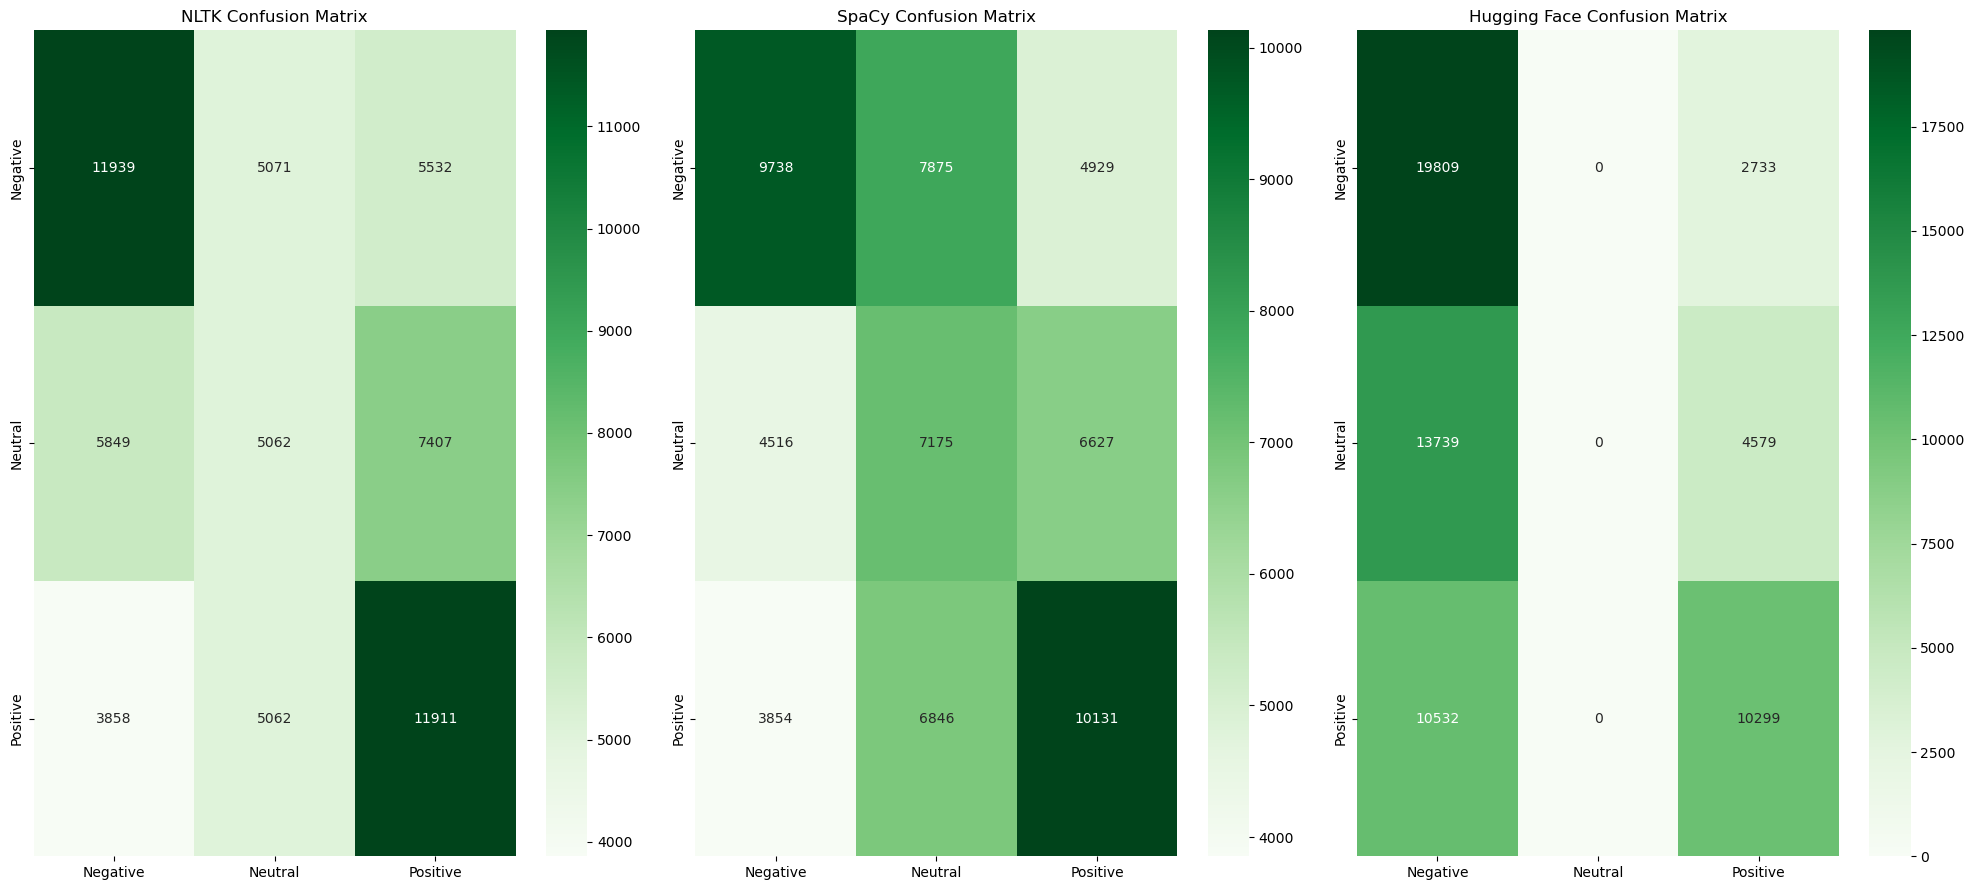

In [ ]:
plt.figure(figsize=(20, 9))
plt.subplot(1, 3, 1)
sns.heatmap(nltk_confusion_matrix, annot=True, cmap="Greens", fmt="d", xticklabels=labels, yticklabels=labels)
plt.title("NLTK Confusion Matrix")

plt.subplot(1, 3, 2)
sns.heatmap(spacy_confusion_matrix, annot=True, cmap="Greens", fmt="d", xticklabels=labels, yticklabels=labels)
plt.title("SpaCy Confusion Matrix")

plt.subplot(1, 3, 3)
sns.heatmap(hugging_face_confusion_matrix, annot=True, cmap="Greens", fmt="d", xticklabels=labels, yticklabels=labels)
plt.title("Hugging Face Confusion Matrix")

plt.tight_layout()
plt.show()

nltk_accuracy = np.trace(nltk_confusion_matrix) / np.sum(nltk_confusion_matrix)
spacy_accuracy = np.trace(spacy_confusion_matrix) / np.sum(spacy_confusion_matrix)
hugging_face_accuracy = np.trace(hugging_face_confusion_matrix) / np.sum(hugging_face_confusion_matrix)
